In [1]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from psmpy import PsmPy
import numpy as np
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

In [2]:
#Set up OMOP database connection

config = configparser.ConfigParser()
config.read('omop_db_config_new.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
cursor = sql_conn.cursor(as_dict=True)

In [3]:
#Functions to query db
def get_data(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    df = pd.DataFrame(results, columns=columns)
    return df

def run_query(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    return None

# Motivation 1: Understanding Opioid Predispositions

## Defining 2 cohorts: opioid_dependent and not_opioid_dependent

In [4]:
#Select people that were prescribed the drug ids for hydrocode/oxycodone (specific list mentioned below)
# concept_name	concept_id
# dexbrompheniramine maleate 0.2 MG/ML / hydrocodone bitartrate 0.5 MG/ML / phenylephrine hydrochloride 1 MG/ML Oral Solution	40165568
# guaifenesin 20 MG/ML / hydrocodone bitartrate 0.5 MG/ML / pseudoephedrine hydrochloride 3 MG/ML Oral Solution	40165842
# oxycodone hydrochloride 1 MG/ML Oral Solution	40232700
# oxycodone hydrochloride 10 MG Oral Tablet	40232707
# oxycodone hydrochloride 15 MG Oral Tablet	40232717
# oxycodone hydrochloride 20 MG/ML Oral Solution	40232735
# oxycodone hydrochloride 30 MG Oral Tablet	40232745
# oxycodone hydrochloride 5 MG Oral Capsule	40232754
# oxycodone hydrochloride 5 MG Oral Tablet	40232756
# acetaminophen 750 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	19133768
# hydrocodone bitartrate 7.5 MG / ibuprofen 200 MG Oral Tablet	40164715
# chlorpheniramine maleate 0.8 MG/ML / hydrocodone bitartrate 1 MG/ML Oral Solution	43525679
# Abuse-Deterrent 24 HR hydrocodone bitartrate 20 MG Extended Release Oral Tablet	45892337
# Abuse-Deterrent 24 HR hydrocodone bitartrate 30 MG Extended Release Oral Tablet	45892345
# Abuse-Deterrent 24 HR hydrocodone bitartrate 40 MG Extended Release Oral Tablet	45892351
# Abuse-Deterrent 24 HR hydrocodone bitartrate 60 MG Extended Release Oral Tablet	45892357
# acetaminophen 650 MG / oxycodone hydrochloride 10 MG Oral Tablet	40231855
# acetaminophen 325 MG / oxycodone hydrochloride 10 MG Oral Tablet	40231916
# acetaminophen 325 MG / oxycodone hydrochloride 5 MG Oral Tablet	40231925
# acetaminophen 325 MG / oxycodone hydrochloride 7.5 MG Oral Tablet	40231932
# Abuse-Deterrent 12 HR oxycodone hydrochloride 20 MG Extended Release Oral Tablet	1718691
# Abuse-Deterrent 12 HR oxycodone hydrochloride 40 MG Extended Release Oral Tablet	1718697
# Abuse-Deterrent 12 HR oxycodone hydrochloride 80 MG Extended Release Oral Tablet	1718699
# Abuse-Deterrent 12 HR oxycodone hydrochloride 15 MG Extended Release Oral Tablet	1718701
# Abuse-Deterrent 12 HR oxycodone hydrochloride 10 MG Extended Release Oral Tablet	1718702
# acetaminophen 500 MG / hydrocodone bitartrate 5 MG Oral Tablet	40162494
# acetaminophen 325 MG / hydrocodone bitartrate 10 MG Oral Tablet	40162511
# acetaminophen 325 MG / hydrocodone bitartrate 5 MG Oral Tablet	40162515
# acetaminophen 325 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	40162522
# acetaminophen 21.7 MG/ML / hydrocodone bitartrate 0.5 MG/ML Oral Solution	40162563
# acetaminophen 21.7 MG/ML / hydrocodone bitartrate 0.67 MG/ML Oral Solution	40162566
# acetaminophen 33.3 MG/ML / hydrocodone bitartrate 0.5 MG/ML Oral Solution	40162587
# acetaminophen 300 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	40162618

drop_table_query = """DROP TABLE IF EXISTS #opioid_presc_population"""

opioid_presc_pop_query = """
WITH PrescriptionFrequency AS (
    SELECT 
        [person_id],
        [drug_concept_id],
        COUNT(*) AS [prescription_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [drug_exposure]
    WHERE [drug_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE ([concept_name] LIKE '%oxycodone%' 
                OR [concept_name] LIKE '%hydrocodone%')
         AND [concept_class_id] = 'Clinical Drug'
         AND [domain_id] = 'Drug')
    GROUP BY [person_id], [drug_concept_id]
),
PrescriptionDetails AS (
    SELECT 
        [person_id],
        MIN([drug_exposure_start_date]) AS [first_presc_date],
        MAX([drug_exposure_start_date]) AS [last_presc_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [drug_exposure]
    WHERE [drug_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE ([concept_name] LIKE '%oxycodone%' 
                OR [concept_name] LIKE '%hydrocodone%')
         AND [concept_class_id] = 'Clinical Drug'
         AND [domain_id] = 'Drug')
    GROUP BY [person_id]
    HAVING COUNT([visit_occurrence_id]) >= 2
)

SELECT 
    pd.[person_id],
    pd.[first_presc_date],
    pd.[last_presc_date],
    pd.[n_visits],
    pf.[drug_concept_id] AS [most_frequent_prescription]
INTO
    #opioid_presc_population
FROM 
    PrescriptionDetails pd
JOIN 
    PrescriptionFrequency pf
ON 
    pd.[person_id] = pf.[person_id]
WHERE 
    pf.rn = 1;
"""
run_query(sql_conn, drop_table_query)
run_query(sql_conn, opioid_presc_pop_query)

In [5]:
#Ensure that their records go back at least 6 months before their first prescription
query = """
SELECT o.*
FROM #opioid_presc_population o
WHERE EXISTS (
    SELECT 1
    FROM observation obs
    WHERE o.person_id = obs.person_id
    AND obs.observation_date <= DATEADD(MONTH, -6, o.first_presc_date)
)
"""

opioid_presc_population = get_data(sql_conn, query)

In [6]:
opioid_presc_population

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription
0,1269483,2012-06-16,2012-06-21,39,40232756
1,1326173,2013-06-06,2013-06-07,8,40162515
2,1404709,2017-02-02,2017-02-02,13,40232756
3,1509769,2015-03-22,2015-03-24,21,40232756
4,1536741,2014-12-19,2014-12-25,74,40232756
...,...,...,...,...,...
124917,10479987,2023-07-07,2023-07-07,4,40232756
124918,10466179,2023-07-16,2023-07-16,3,40232756
124919,10413547,2023-01-09,2023-07-10,17,40232756
124920,10406727,2022-12-09,2022-12-13,31,40232756


In [7]:
# Create a table of opioid dependent people
# concept_name	concept_id
# Opioid abuse with withdrawal	725281
# Opioid abuse with opioid-induced mood disorder	45566782
# Opioid dependence with opioid-induced psychotic disorder, unspecified	45566784
# Opioid dependence with other opioid-induced disorder	45566785
# Opioid abuse with unspecified opioid-induced disorder	45576500
# Opioid abuse, unspecified	44819555
# Opioid abuse with intoxication, uncomplicated	45542792
# Opioid abuse with opioid-induced sexual dysfunction	45542793
# Opioid abuse with other opioid-induced disorder	45542794
# Opioid dependence with intoxication, uncomplicated	45542795
# Opioid dependence with intoxication delirium	45542796
# Opioid abuse, in remission	44834602
# Opioid abuse, continuous	44822989
# Opioid dependence with opioid-induced sleep disorder	45533067
# Opioid dependence with opioid-induced psychotic disorder with hallucinations	45591090
# Opioid dependence with opioid-induced sexual dysfunction	45591091
# Opioid abuse with intoxication delirium	45571712
# Opioid abuse	44827668
# Opioid abuse, episodic	44829939
# Opioid dependence with intoxication, unspecified	45557159
# Opioid dependence with withdrawal	45557160
# Opioid abuse with intoxication, unspecified	45581409
# Opioid dependence, uncomplicated	45586193
# Opioid abuse, in remission	1326498
# Opioid abuse with opioid-induced psychotic disorder, unspecified	45562007
# Opioid dependence with opioid-induced psychotic disorder with delusions	45595854
# Opioid abuse with intoxication with perceptual disturbance	45600697
# Opioid abuse, uncomplicated	45605458
# Opioid dependence, in remission	45605459
# Opioid dependence with opioid-induced mood disorder	45605460
# Opioid dependence with unspecified opioid-induced disorder	45605461

opioid_dep_pop_query = """
WITH ConditionFrequency AS (
    SELECT 
        [person_id],
        [condition_concept_id],
        COUNT(*) AS [condition_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE ([concept_name] LIKE '%opioid dependence%'
         OR [concept_name] LIKE '%opioid abuse%')
         AND [domain_id] = 'Condition')
    GROUP BY [person_id], [condition_concept_id]
)
, DiagnosisDetails AS (
    SELECT 
        [person_id],
        MIN([condition_start_date]) AS [first_diagnosis_date],
        MAX([condition_start_date]) AS [last_diagnosis_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [concept]
         WHERE ([concept_name] LIKE '%opioid dependence%'
         OR [concept_name] LIKE '%opioid abuse%')
         AND [domain_id] = 'Condition')
    GROUP BY [person_id]
)
SELECT 
    d.[person_id],
    d.[first_diagnosis_date],
    d.[last_diagnosis_date],
    d.[n_visits],
    cf.[condition_concept_id] AS [most_frequent_condition]
FROM 
    DiagnosisDetails d
JOIN 
    ConditionFrequency cf
ON 
    d.[person_id] = cf.[person_id]
WHERE 
    cf.rn = 1
    AND d.[n_visits] >= 2;
"""
opioid_dep_population = get_data(sql_conn, opioid_dep_pop_query)

In [8]:
# Add a column to opioid_presc_population to say if they are addicted, then split into 2 tables

#TODO: Should I use first or last presc date to add 6 months to before seeing if a diagnosis appears? Using first rn.

merged_opioid = pd.merge(opioid_presc_population, opioid_dep_population[['person_id', 'first_diagnosis_date', 'most_frequent_condition']], 
                     on='person_id', how='left')

merged_opioid['dependent'] = (merged_opioid['first_diagnosis_date'] >= merged_opioid['first_presc_date'] + relativedelta(months=6))

merged_opioid['most_frequent_condition'] = merged_opioid['most_frequent_condition'].fillna(0).astype('int64')
op_addicted = merged_opioid[merged_opioid['dependent']]

#Filters for people who had opioid dependence diagnosed before or up to 6 months after their first prescription
not_op_addicted = merged_opioid[merged_opioid['dependent'] == False]
not_op_addicted = not_op_addicted[not_op_addicted['first_diagnosis_date'].isna()]

In [9]:
#Perform filters on not_opioid_dependent population: ensure they have a visit after 6 months

#Create Table with Filtered Opioid patient IDs
not_op_addicted_ids = not_op_addicted.person_id.to_list()
not_op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in not_op_addicted_ids])
not_op_addicted_ids = '(' + not_op_addicted_ids + ')'
not_op_addicted_ids = not_op_addicted_ids.split(', ')

query = f"""
DROP TABLE IF EXISTS #not_op_patient_ids;
CREATE TABLE #not_op_patient_ids (cond_id INT);
"""

for subject_id in not_op_addicted_ids:
    query += f"""
INSERT INTO #not_op_patient_ids (cond_id)
VALUES {subject_id};
"""
run_query(sql_conn, query)

#choose visit ocurrences that match the ids of not_op_addicted population
visits_not_op_query = """
    SELECT DISTINCT [visit_start_date],
	[person_id]
  FROM [visit_occurrence]
  WHERE [person_id] IN (
    SELECT cond_id FROM #not_op_patient_ids
  )
"""
visits_not_op = get_data(sql_conn, visits_not_op_query)


#Only keep the records that have a visit ocurrence >= 6 months from the first prescription
merged_not_op = not_op_addicted.merge(visits_not_op, on = 'person_id', how = 'left')
filtered_merged_not_op = merged_not_op[merged_not_op['visit_start_date'] >= merged_not_op['first_presc_date'] + relativedelta(months=6)]['person_id'].unique()
not_op_addicted = not_op_addicted[not_op_addicted['person_id'].isin(filtered_merged_not_op)]

In [10]:
not_op_addicted

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent
0,1269483,2012-06-16,2012-06-21,39,40232756,NaN,0,False
1,1326173,2013-06-06,2013-06-07,8,40162515,NaN,0,False
4,1536741,2014-12-19,2014-12-25,74,40232756,NaN,0,False
5,1608663,2018-03-28,2018-03-28,2,40162515,NaN,0,False
6,326144,2018-03-20,2018-03-21,9,40232756,NaN,0,False
...,...,...,...,...,...,...,...,...
124914,10407306,2021-08-15,2021-08-15,2,40232756,NaN,0,False
124915,10417477,2022-09-12,2023-02-24,9,40232756,NaN,0,False
124917,10479987,2023-07-07,2023-07-07,4,40232756,NaN,0,False
124919,10413547,2023-01-09,2023-07-10,17,40232756,NaN,0,False


In [11]:
op_addicted

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent
185,1190427,2019-04-05,2023-02-09,26,40232756,2019-12-07,438120,True
472,1294727,1994-11-14,1995-08-14,3,1718699,2001-05-26,434016,True
1079,3085465,2012-05-04,2016-04-14,240,40232756,2016-03-29,438120,True
1133,1687475,2021-03-09,2023-02-21,23,40232756,2023-02-19,438120,True
1524,530989,2010-10-17,2015-06-05,25,40162494,2011-10-29,438120,True
...,...,...,...,...,...,...,...,...
124521,9757292,2010-11-15,2018-06-26,125,40162515,2012-04-04,438130,True
124579,10133289,2017-08-29,2022-06-25,100,40232756,2019-07-16,438120,True
124652,9706233,2011-08-24,2020-08-18,60,40232756,2013-02-23,438120,True
124681,10171359,2016-08-08,2018-07-26,179,40232756,2018-05-14,438120,True


In [12]:
not_op_addicted.to_feather("data/not_op_addicted.feather")
op_addicted.to_feather("data/op_addicted.feather")

## Add Age and Sex Data for Propensity Score Matching

In [13]:
#Create Table with addicted patient IDs
op_addicted_ids = op_addicted.person_id.to_list()
op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in op_addicted_ids])
op_addicted_ids = '(' + op_addicted_ids + ')'
op_addicted_ids = op_addicted_ids.split(', ')

query_op_ids = f"""
DROP TABLE IF EXISTS #op_addicted_patient_ids;
CREATE TABLE #op_addicted_patient_ids (person_id INT);
"""

for subject_id in op_addicted_ids:
    query_op_ids += f"""
INSERT INTO #op_addicted_patient_ids (person_id)
VALUES {subject_id};
"""
    
run_query(sql_conn, query_op_ids)

#Add age and sex info to table
op_bio_query = """
SELECT
    p.person_id, 
    p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value

FROM
    #op_addicted_patient_ids op
    
    JOIN [person] p
        ON op.person_id = p.person_id
"""

op_addicted = op_addicted.merge(get_data(sql_conn, op_bio_query), on = 'person_id', how = 'left')

In [14]:
#Create Bio table for non-addicted population
not_op_addicted_ids = not_op_addicted.person_id.to_list()
not_op_addicted_ids = '), ('.join([str(subject_ids) for subject_ids in not_op_addicted_ids])
not_op_addicted_ids = '(' + not_op_addicted_ids + ')'
not_op_addicted_ids = not_op_addicted_ids.split(', ')

query_not_op_ids = f"""
DROP TABLE IF EXISTS #not_op_addicted_patient_ids;
CREATE TABLE #not_op_addicted_patient_ids (person_id INT);
"""

for subject_id in not_op_addicted_ids:
    query_not_op_ids += f"""
INSERT INTO #not_op_addicted_patient_ids (person_id)
VALUES {subject_id};
"""
    
run_query(sql_conn, query_not_op_ids)

#Add age and sex info to table
n_op_bio_query = """
SELECT
    p.person_id, p.gender_source_value, 
    2024 - p.year_of_birth AS age, 
    p.ethnicity_source_value

FROM
    #not_op_addicted_patient_ids n_op
    
    JOIN [person] p
        ON n_op.person_id = p.person_id
"""

not_op_addicted = not_op_addicted.merge(get_data(sql_conn, n_op_bio_query), on = 'person_id', how = 'left')

In [15]:
op_addicted

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,gender_source_value,age,ethnicity_source_value
0,1190427,2019-04-05,2023-02-09,26,40232756,2019-12-07,438120,True,Male,62,Hispanic or Latino
1,1294727,1994-11-14,1995-08-14,3,1718699,2001-05-26,434016,True,Male,70,Not Hispanic or Latino
2,3085465,2012-05-04,2016-04-14,240,40232756,2016-03-29,438120,True,Male,65,Not Hispanic or Latino
3,1687475,2021-03-09,2023-02-21,23,40232756,2023-02-19,438120,True,Female,42,Not Hispanic or Latino
4,530989,2010-10-17,2015-06-05,25,40162494,2011-10-29,438120,True,Female,91,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...,...,...,...
1109,9757292,2010-11-15,2018-06-26,125,40162515,2012-04-04,438130,True,Male,66,Not Hispanic or Latino
1110,10133289,2017-08-29,2022-06-25,100,40232756,2019-07-16,438120,True,Male,60,Not Hispanic or Latino
1111,9706233,2011-08-24,2020-08-18,60,40232756,2013-02-23,438120,True,Male,75,Not Hispanic or Latino
1112,10171359,2016-08-08,2018-07-26,179,40232756,2018-05-14,438120,True,Female,40,Not Hispanic or Latino


In [16]:
not_op_addicted

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,gender_source_value,age,ethnicity_source_value
0,1269483,2012-06-16,2012-06-21,39,40232756,NaN,0,False,Male,65,Not Hispanic or Latino
1,1326173,2013-06-06,2013-06-07,8,40162515,NaN,0,False,Female,30,Not Hispanic or Latino
2,1536741,2014-12-19,2014-12-25,74,40232756,NaN,0,False,Female,23,Hispanic or Latino
3,1608663,2018-03-28,2018-03-28,2,40162515,NaN,0,False,Female,42,Hispanic or Latino
4,326144,2018-03-20,2018-03-21,9,40232756,NaN,0,False,Female,73,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...,...,...,...
108694,10407306,2021-08-15,2021-08-15,2,40232756,NaN,0,False,Female,35,Unknown
108695,10417477,2022-09-12,2023-02-24,9,40232756,NaN,0,False,Male,34,Hispanic or Latino
108696,10479987,2023-07-07,2023-07-07,4,40232756,NaN,0,False,Female,36,Not Hispanic or Latino
108697,10413547,2023-01-09,2023-07-10,17,40232756,NaN,0,False,Male,76,Hispanic or Latino


# Perform Propensity Score Matching on Age, Sex, Length of Prescription

In [17]:
full_bio_cohort = pd.concat([op_addicted, not_op_addicted], axis=0, ignore_index=True)
full_bio_cohort['presc_length'] = full_bio_cohort.apply(
    lambda r: int((r['last_presc_date'] - r['first_presc_date']).days), axis=1
)
full_bio_cohort['gender_source_value'] = full_bio_cohort['gender_source_value'].map({'Male': 0, 'Female': 1}).fillna(2).astype(int)

# Create an instance of PsmPy
prop_sm = PsmPy(full_bio_cohort[['person_id', 'gender_source_value', 'age', 'dependent', 'most_frequent_prescription', 'presc_length']], treatment='dependent', indx='person_id')

# Calculate the propensity scores based on sex and age
prop_sm.logistic_ps(balance=True)

# Perform matching, with a ratio of 15 controls to each test subject
prop_sm.knn_matched_12n(matcher='propensity_logit', how_many=15)

#List of final ids for cohort, after matching
final_cohort_ids = prop_sm.matched_ids.values.ravel()

In [18]:
prop_sm.matched_ids

,person_id,largerclass_0group,largerclass_1group,largerclass_2group,largerclass_3group,largerclass_4group,largerclass_5group,largerclass_6group,largerclass_7group,largerclass_8group,largerclass_9group,largerclass_10group,largerclass_11group,largerclass_12group,largerclass_13group,largerclass_14group
0,1190427,8719592,3787454,9594181,8023010,8110588,9110731,8074526,328233,9332849,8068011,8555121,8813262,8130906,8246778,2171355
1,1294727,9251671,1306827,8898435,9580140,8799542,9061641,8615816,1670118,9309148,2210685,1422315,8438988,8209692,8380892,8961311
2,3085465,9308155,8638039,8253667,7098105,8340536,8703333,9125855,9052451,8808192,7372581,8036261,1588869,4905275,8223229,8272040
3,1687475,9250676,241863,8529546,9071224,8246125,8237889,9556236,8834703,9516077,7943717,1778159,8494946,7221988,7886968,8086419
4,530989,9598012,8325872,7837422,8925620,9249574,4623731,8895146,9303209,9339755,8395784,8803277,9465606,9153140,256526,4963558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,9757292,8329349,9036785,9512675,9281459,9287453,9349290,8163286,8995473,3213901,3675328,9161259,9532373,9398110,8493478,6106717
1110,10133289,9487738,9520086,9269028,9491982,37533,8751991,2899310,8060092,9054498,703351,8803069,8876606,9213341,8334414,9367513
1111,9706233,9569576,9471658,797126,8451152,8111501,8625026,8004546,8133881,8178254,9211704,8954940,8643222,9546270,8762818,8088850
1112,10171359,9143558,6422600,8931476,9169973,7919923,8856277,8622448,8918854,8546094,7919180,9073580,589165,8494831,9061536,8839085


In [19]:
#save the ids list so don't need to re-run PSM
prop_sm.matched_ids.to_feather("data/opioid_cohort_ids.feather")

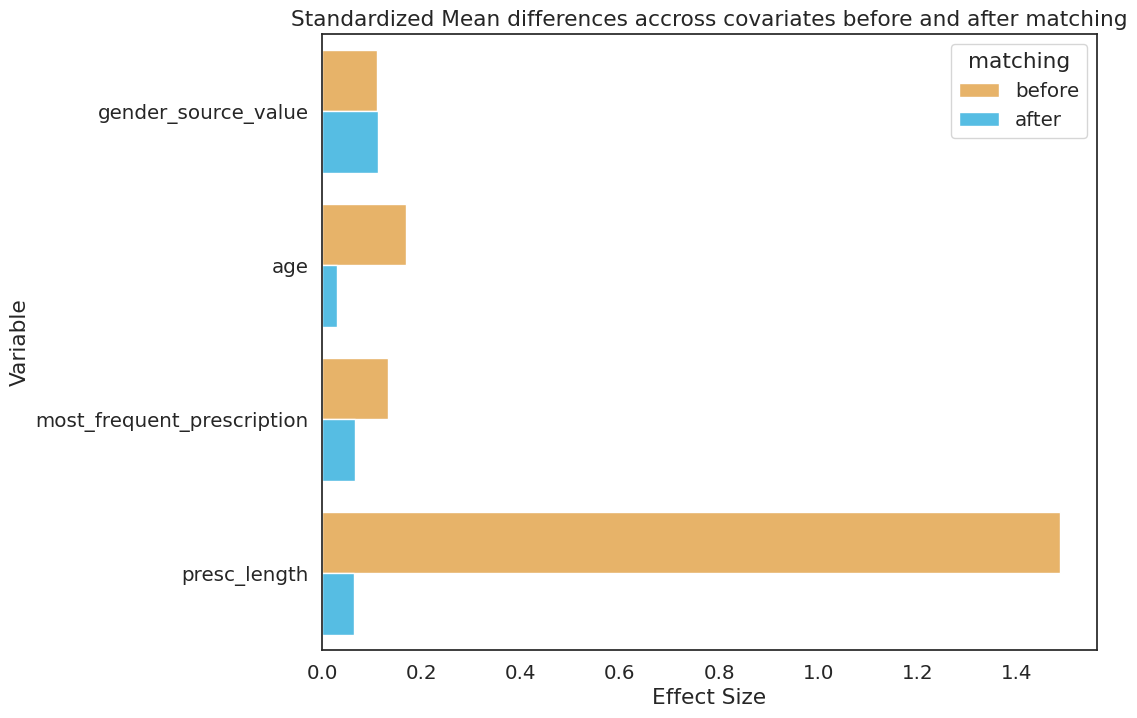

In [20]:
prop_sm.effect_size_plot()

# Create MetaTables for Each ID After PSM

In [4]:
#Run this if you rerunning
op_addicted = pd.read_feather("data/op_addicted.feather")
not_op_addicted = pd.read_feather("data/not_op_addicted.feather")
psm_ids = pd.read_feather("data/opioid_cohort_ids.feather")
final_cohort_ids = psm_ids.values.ravel()

In [5]:
#Change not_op and full_bio_cohort to reflect the PSM matching
not_op_addicted = not_op_addicted[not_op_addicted['person_id'].isin(final_cohort_ids)]

full_bio_cohort = pd.concat([op_addicted, not_op_addicted], axis=0, ignore_index=True)
# full_bio_cohort = full_bio_cohort[full_bio_cohort['person_id'].isin(final_cohort_ids)]
full_bio_cohort['cutoff_date'] = full_bio_cohort['first_presc_date'] + relativedelta(months=6)

In [6]:
full_bio_cohort

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,cutoff_date
0,1190427,2019-04-05,2023-02-09,26,40232756,2019-12-07,438120,True,2019-10-05
1,1294727,1994-11-14,1995-08-14,3,1718699,2001-05-26,434016,True,1995-05-14
2,3085465,2012-05-04,2016-04-14,240,40232756,2016-03-29,438120,True,2012-11-04
3,1687475,2021-03-09,2023-02-21,23,40232756,2023-02-19,438120,True,2021-09-09
4,530989,2010-10-17,2015-06-05,25,40162494,2011-10-29,438120,True,2011-04-17
...,...,...,...,...,...,...,...,...,...
17819,10184203,2012-03-28,2013-03-20,3,40162515,None,0,False,2012-09-28
17820,10224355,2015-04-07,2022-06-10,5,40162515,None,0,False,2015-10-07
17821,9635335,2010-10-31,2023-01-15,137,40162511,None,0,False,2011-04-30
17822,9639145,2018-06-23,2019-12-15,105,40232700,None,0,False,2018-12-23


In [7]:
# Create a SQL table with the full cohort ids + date 6 months after their prescription (cut-off after which dependencies can be diagnosed). This will be used to find relevant concepts and encode them for SPOKE
query_EHR_concept_ref = f"""
DROP TABLE IF EXISTS #ehr_concept_ref;
CREATE TABLE #ehr_concept_ref (person_id INT, cutoff_date DATE);
"""

for index, row in full_bio_cohort.iterrows():
    query_EHR_concept_ref += f"""
INSERT INTO #ehr_concept_ref (person_id, cutoff_date)
VALUES ({row['person_id']}, '{row['cutoff_date']}');
"""

run_query(sql_conn, query_EHR_concept_ref)

In [8]:
#Creating concept metatables for drug and conditions (labs are harder, done below)— did not choose to include person qualities

# query_person_mt = """
# SELECT p.[person_id]
#     ,[race_concept_id]
#     ,[ethnicity_concept_id]
# FROM [person] p
# JOIN #ehr_concept_ref ref ON p.person_id = ref.person_id;
# """
# person_mt = get_data(sql_conn, query_person_mt).drop_duplicates()
# person_mt = pd.melt(person_mt, id_vars=['person_id'], 
#                     value_vars=['race_concept_id', 'ethnicity_concept_id'],
#                     value_name='concept').drop(['variable'], axis = 1)

query_drugs_mt = """
SELECT d.[person_id]
    ,[drug_concept_id] AS concept
FROM [drug_exposure] d
JOIN #ehr_concept_ref ref ON d.person_id = ref.person_id
WHERE d.drug_exposure_start_date < ref.cutoff_date;
"""
drugs_mt = get_data(sql_conn, query_drugs_mt).drop_duplicates()

query_conditions_mt = """
SELECT c.[person_id]
    ,[condition_concept_id] AS concept
FROM [condition_occurrence] c
JOIN #ehr_concept_ref ref ON c.person_id = ref.person_id
WHERE c.condition_start_date < ref.cutoff_date;
"""
conditions_mt = get_data(sql_conn, query_conditions_mt).drop_duplicates()

## Getting Lab Tests 😵‍💫

In [9]:
#First get the person_source_values, this is the key to mapping OMOP to CDW
person_source_values_query = """
SELECT ehr.person_id, p.person_source_value, ehr.cutoff_date
FROM #ehr_concept_ref AS ehr
JOIN person AS p ON ehr.person_id = p.person_id;
"""
omop_spoke_sourcevalues = get_data(sql_conn, person_source_values_query)

In [10]:
#Set up CDW database connection
config = configparser.ConfigParser()
config.read('cdw_db_config.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

cdw_sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
sql_cursor = cdw_sql_conn.cursor(as_dict=True)


In [11]:
#Recreate the OMOP->CDW table in the CDW SQL driver
query_person_sv = f"""
DROP TABLE IF EXISTS #person_source_values;
CREATE TABLE #person_source_values (person_id INT, person_source_value VARCHAR(20), cutoff_date DATE);
"""

for index, row in omop_spoke_sourcevalues.iterrows():
    query_person_sv += f"""
INSERT INTO #person_source_values (person_id, person_source_value, cutoff_date)
VALUES ({row['person_id']}, '{row['person_source_value']}', '{row['cutoff_date']}');
"""
    
run_query(cdw_sql_conn, query_person_sv)

In [12]:
#Create a table of LOINC IDs each id got prescribed
abnormal_lab_query = """
WITH PersonToDurableKey AS (
    SELECT ps.person_id, ps.cutoff_date, pdd.PatientDurableKey
    FROM [CDW_NEW].[deid_uf].[PatDurableDim] AS pdd
    JOIN #person_source_values AS ps ON ps.person_source_value = pdd.PatientEpicId
)

SELECT pd.person_id, lcrf.ComponentLoincCode AS concept
    FROM PersonToDurableKey AS pd
    JOIN [CDW_NEW].[deid_uf].LabComponentResultFact AS lcrf ON pd.PatientDurableKey = lcrf.PatientDurableKey
    WHERE lcrf.Abnormal = 1 AND lcrf.CollectionDateKeyValue < pd.cutoff_date
"""

labs_mt = get_data(cdw_sql_conn, abnormal_lab_query).drop_duplicates()

In [13]:
#Recreate the LOINC table in the OMOP SQL driver to map to OMOP concepts
query_loinc_codes = f"""
DROP TABLE IF EXISTS #loinc_ids;
CREATE TABLE #loinc_ids (person_id INT, loinc_id VARCHAR(20));
"""

for index, row in labs_mt.iterrows():
    query_loinc_codes += f"""
INSERT INTO #loinc_ids (person_id, loinc_id)
VALUES ({row['person_id']}, '{row['concept']}');
"""
    
run_query(sql_conn, query_loinc_codes)

In [17]:
#Get the OMOP concepts from the LOINC IDs
query_loinc_to_omop = f"""
SELECT l.person_id, c.concept_id AS concept
FROM #loinc_ids AS l
INNER JOIN concept AS c ON l.loinc_id = c.concept_code;
"""

labs_mt = get_data(sql_conn, query_loinc_to_omop)

In [18]:
labs_mt

,person_id,concept
0,1863349,3006906
1,6789105,3006906
2,8460660,3006906
3,8392640,3006906
4,7846894,3006906
...,...,...
327713,7231802,3008152
327714,8543592,3008152
327715,1138927,3008152
327716,8804380,3008152


# Translate Concepts to SPOKE Codes, Formatting for SEPs

In [19]:
#Translating conditions
# disease_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_conditions_to_spoke_extended_2.tsv', sep = '\t')

disease_annotation = pd.read_csv('../../gbellucci/spoke_linkers/omop2spoke_combined.tsv', sep = '\t')
disease_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
disease_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(disease_annotation['condition_concept_id'], disease_annotation['spoke_concept_id']))

conditions_mt['spoke_code'] = conditions_mt['concept'].map(omop_to_spoke_dict)

#Translating Drugs
drug_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_drug_exposure_to_spoke_extended.tsv', sep = '\t')
drug_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
drug_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(drug_annotation['condition_concept_id'], drug_annotation['spoke_concept_id']))

drugs_mt['spoke_code'] = drugs_mt['concept'].map(omop_to_spoke_dict)

#Translating measurements
lab_annotation = pd.read_csv('../../psev_repo/omop_sep_map/filtered_omop_measurement_to_spoke_extended.tsv', sep = '\t')
lab_annotation.rename(columns={'OMOP': 'condition_concept_id'}, inplace=True)
lab_annotation.rename(columns={'SPOKE': 'spoke_concept_id'}, inplace=True)

omop_to_spoke_dict = dict(zip(lab_annotation['condition_concept_id'], lab_annotation['spoke_concept_id']))

labs_mt['spoke_code'] = labs_mt['concept'].map(omop_to_spoke_dict)

In [27]:
#Can see which codes were not matched to a SPOKE node

# conditions_mt[conditions_mt['spoke_code'].isna()]['concept'].tolist()
# len(drugs_mt[drugs_mt['spoke_code'].isna()]['concept'].tolist())
# labs_mt[labs_mt['spoke_code'].isna()]['concept'].nunique()

In [28]:
#One hot encode all the concepts

#Drop anything that wasn't mapped to SPOKE
concepts_ehr = pd.concat([drugs_mt, conditions_mt, labs_mt], ignore_index=True)
concepts_ehr = concepts_ehr[concepts_ehr['spoke_code'].notna()]

#Drop repeat spoke codes (multiple OMOP map to single SPOKE)
concepts_ehr = concepts_ehr[['person_id', 'spoke_code']].drop_duplicates()

# Create dummy variables
dummies = pd.get_dummies(concepts_ehr['spoke_code'])

# Concatenate with the original DataFrame to have IDs
df_with_dummies = pd.concat([concepts_ehr[['person_id']], dummies], axis=1)

# Group by 'person_id' and sum up the dummy columns to avoid multiple rows for the same person
#doing this in chunks since takes too much memory to use groupby directly
chunk_size = 10000
results = []

# Process the DataFrame in chunks
num_chunks = (len(df_with_dummies) // chunk_size) + 1  # Calculate total number of chunks
for start in tqdm(range(0, len(df_with_dummies), chunk_size)):
    chunk = df_with_dummies.iloc[start:start + chunk_size]
    
    # Perform the groupby and aggregation for the current chunk
    chunk_result = chunk.groupby('person_id').sum().reset_index()
    
    # Append the chunk result to the results list
    results.append(chunk_result)
    
# Concatenate all chunk results into a final DataFrame
final_df = pd.concat(results, ignore_index=True)

# Final aggregation to ensure no duplicates (in case of overlapping person_ids across chunks)
final_df = final_df.groupby('person_id').sum().reset_index()

100%|██████████| 55/55 [00:47<00:00,  1.15it/s]


In [29]:
# Makes sure that one-hot encoding works, should not be >1 for any cell (except for person_id column) — Should be False
(final_df.iloc[:, 1:] > 1).any().any()

np.False_

In [30]:
final_df.to_feather("data/opioid_concept_map.feather")
full_bio_cohort.to_feather('data/opioid_cohort_details.feather')

In [31]:
final_df

,person_id,C0032961,C0041296,C0151632,CHEMBL112570,CHEMBL1166,CHEMBL1200830,CHEMBL1222250,CHEMBL1618018,CHEMBL2146121,...,UBERON:0001088,UBERON:0001089,UBERON:0001135,UBERON:0001264,UBERON:0001690,UBERON:0001968,UBERON:0001969,UBERON:0001970,UBERON:0001988,UBERON:0002113
0,304,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1516,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,4565,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5127,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,7451,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17792,10446618,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17793,10458182,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
17794,10458349,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
17795,10509936,1,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [32]:
full_bio_cohort

,person_id,first_presc_date,last_presc_date,n_visits,most_frequent_prescription,first_diagnosis_date,most_frequent_condition,dependent,cutoff_date
0,1190427,2019-04-05,2023-02-09,26,40232756,2019-12-07,438120,True,2019-10-05
1,1294727,1994-11-14,1995-08-14,3,1718699,2001-05-26,434016,True,1995-05-14
2,3085465,2012-05-04,2016-04-14,240,40232756,2016-03-29,438120,True,2012-11-04
3,1687475,2021-03-09,2023-02-21,23,40232756,2023-02-19,438120,True,2021-09-09
4,530989,2010-10-17,2015-06-05,25,40162494,2011-10-29,438120,True,2011-04-17
...,...,...,...,...,...,...,...,...,...
17819,10184203,2012-03-28,2013-03-20,3,40162515,None,0,False,2012-09-28
17820,10224355,2015-04-07,2022-06-10,5,40162515,None,0,False,2015-10-07
17821,9635335,2010-10-31,2023-01-15,137,40162511,None,0,False,2011-04-30
17822,9639145,2018-06-23,2019-12-15,105,40232700,None,0,False,2018-12-23


In [49]:
#Find all events where alcohol dependence was diagnosed— Includes these conditions
# concept_name	concept_id
# Other and unspecified alcohol dependence, continuous	44825305
# Alcohol dependence with alcohol-induced mood disorder	45562002
# Alcohol dependence with alcohol-induced psychotic disorder with delusions	45562003
# Other and unspecified alcohol dependence	44819550
# Other and unspecified alcohol dependence, episodic	44819551
# Alcohol dependence, in remission	45581405
# Alcohol dependence with withdrawal delirium	45552431
# Other and unspecified alcohol dependence, unspecified	44831100
# Alcohol dependence with withdrawal with perceptual disturbance	45566775
# Alcohol dependence with alcohol-induced persisting dementia	45566776
# Alcohol dependence with alcohol-induced anxiety disorder	45566777
# Alcohol dependence with intoxication, unspecified	45538007
# Alcohol dependence with unspecified alcohol-induced disorder	45591084
# Other and unspecified alcohol dependence, in remission	44828838
# Alcohol dependence with alcohol-induced persisting amnestic disorder	45595847
# Alcohol dependence with alcohol-induced sleep disorder	45600696
# Alcohol dependence with alcohol-induced psychotic disorder with hallucinations	45557155
# Alcohol dependence syndrome	44832244
# Alcohol dependence with withdrawal, unspecified	45533065
# Alcohol dependence with alcohol-induced psychotic disorder, unspecified	45571708
# Alcohol dependence with other alcohol-induced disorder	45571709
# Alcohol dependence, uncomplicated	45586187
# Alcohol dependence with intoxication, uncomplicated	45586188
# Alcohol dependence with intoxication delirium	45586189
# Alcohol dependence with withdrawal, uncomplicated	45586190

alc_dep_pop_query = f"""

WITH ConditionFrequency AS (
    SELECT 
        [person_id],
        [condition_concept_id],
        COUNT(*) AS [condition_frequency],
        ROW_NUMBER() OVER (PARTITION BY [person_id] ORDER BY COUNT(*) DESC) AS rn
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[omop].[concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
    GROUP BY [person_id], [condition_concept_id]
)
, DiagnosisDetails AS (
    SELECT 
        [person_id],
        MIN([condition_start_date]) AS [first_diagnosis_date],
        MAX([condition_start_date]) AS [last_diagnosis_date],
        COUNT([visit_occurrence_id]) AS [n_visits]
    FROM [condition_occurrence]
    WHERE [condition_concept_id] IN 
        (SELECT [concept_id]
         FROM [OMOP_DEID].[omop].[concept]
         WHERE [concept_name] LIKE '%alcohol dependence%'
         AND [domain_id] = 'Condition')
    GROUP BY [person_id]
)
SELECT 
    d.[person_id],
    d.[first_diagnosis_date],
    d.[last_diagnosis_date],
    d.[n_visits],
    cf.[condition_concept_id] AS [most_frequent_condition]
FROM 
    DiagnosisDetails d
JOIN 
    ConditionFrequency cf
ON 
    d.[person_id] = cf.[person_id]
WHERE 
    cf.rn = 1
    AND d.[n_visits] >= 2;
"""
alc_dep_population = get_data(sql_conn, alc_dep_pop_query)